<figure>
  <IMG SRC="https://raw.githubusercontent.com/mbakker7/exploratory_computing_with_python/master/tudelft_logo.png" WIDTH=250 ALIGN="right">
</figure>

# An Introduction to the Finite Diffence Method
*Mark Bakker*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Introduction

The finite difference method is a grid-based method. The model area is divided in a grid of rectangular cells. The head is computed at the center of the rectangles and the flow is computed between cells. Cells are numbered row-wise. For example, a grid with 3 rows and 4 columns is numbered as

$$
\begin{array}{|c|c|c|c|}
\hline 
    0&1&2&3 \\ \hline 
    4&5&6&7 \\ \hline 
    8&9&10&11 \\ \hline 
\end{array}$$

The reason for this numbering system is that Python stores two-dimensional arrays in this order.

In [2]:
a = np.arange(12)
a.shape = (3,4)
print(a)

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]]


For a system with $n_c$ columns, the neighbors of cell $i$ (counter-clockwise starting from the right side) are $i+1$, $i-n_c$, $i-1$, and $i+n_c$, as shown below.


$$
\begin{array}{|c|c|c|}
\hline 
    & i-n_c &  \\ \hline
    i-1 & i & i+1 \\\hline
       & i+n_c &  \\\hline
\end{array}$$


Finite difference equations are derived by considering a volume balance for one cell. The cell discharge is defined as the total discharge [L$^3$/T] from one cell to another cell. The cell discharge through the right side of cell $i$ is called $U_i$ and the cell discharge through the front side of cell $i$ is called $V_i$ (see Figure). 

![](fd_fig1.png)

Using this convention, the cell discharge through the left side is $U_{i-1}$ and through the back side is $V_{i-n_c}$. Cell discharges through the right side are positive for flow to the right, and cell discharges through the front side are positive for flow to the front. For steady-state conditions, continuity of flow states that

$$\text{In} = \text{Out}$$

or

$$U_{i-1}+V_{i-n_c} + Q_i = U_i + V_i$$

where $Q_i$ is the source term of cell $i$, the discharge [L$^3$/T] that flows into cell $i$ from outside sources like wells or areal infiltration. The continuity equation is more commonly written as

$$U_i + V_i - U_{i-1} - V_{i-n_c} = Q_i$$

## Flow between two cells

Before considering the flow between two cells, consider one-dimensional flow between two canals with head $h_1$ in the left canal and $h_2$ in the right canal. The hydraulic conductivity between the two canals consists of two zones. The left zone has length $L_1/2$, hydraulic conductivity $k_1$, and thickness $H_1$ so that $T_1=k_1H_1$. The right zone has length $L_2/2$, hydraulic conductivity $k_2$, and thickness $H_2$ so that $T_2=k_2H_2$. The total width of the canal, normal to the plane of flow, is $W$. The total discharge [L$^3$/T] from the left canal to the right canal may be written as

$$Q = W \frac{2T_1 T_2}{T_2 L_1 + T_1 L_2} (h_1 - h_2)$$

This means that the discharge between the two canals can be written as a factor times the head difference between the two canals. 

The total discharge $U_i$ from cell $i$ to cell $i+1$ can be written in the form

$$U_i = C_i(h_i-h_{i+1})$$

where $C_i$ is called the conductance from cell $i$ to cell $i+1$ through the right side of cell $i$, which can be written as

$$C_i = W_i \frac{2T_{i} T_{i+1}}{T_{i+1} L_i + T_i L_{i+1}} $$

Similarly, the total discharge $V_i$ from cell $i$ to cell $i+n_c$ can be written as

$$V_i = D_i(h_i-h_{i+n_c})$$

where $D_i$ is the conductance from cell $i$ to cell $i+n_c$ through the front side of cell $i$

$$D_i = L_i \frac{2T_{i} T_{i+n_c}}{T_{i+n_c} W_i + T_i W_{i+n_c}} $$

## Governing equation

Substitution of the equation for the flow through the right face and the front face into the water balance gives

$$C_i(h_i - h_{i+1}) + D_i(h_i - h_{i+n_c}) - C_{i-1}(h_{i-1}-h_i) - D_{i-n_c}(h_{i-n_c}-h_i) = Q_i$$

or, after some rearrangement

$$C_i h_{i+1} + D_i h_{i+n_c} + C_{i-1} h_{i-1} + D_{i-n_c} h_{i-n_c} - 
(C_i + D_i + C_{i-1} + D_{i-n_c}) h_i = -Q_i$$

Notice that the term in front of $h_i$ is negative the sum of the conductances of the four other terms in the equation. The above equation is valid for each cell, but we have to define a special rule if a cell has one or more sides that form the boundary of a model. Let’s agree that if a cell has a side that is along the boundary, than the conductance of the side along the boundary is zero. As such, all the boundaries of the model are impermeable. (We will modify this later on, but this is our basic model.) For example, consider cell 7 in the system of 4 by 4 cells that was shown earlier. The conductance of its right side is zero: $C_7=0$, so that the water balance equation reduces to

$$D_7 h_{11} + C_{6} h_{6} + D_{3} h_{3} - 
(D_7 + C_{6} + D_{3}) h_7 = -Q_7$$

Note again, that the term in front of $h_7$ is minus the sum of the conductances in front of the other terms. Interestingly enough, this holds for all boundary cells, and thus for any cell in the model. We will make use of this feature later on.

## Building the system of equations

We have a water balance equation for every cell. The total number of unknown heads is equal to the number of rows times the number of columns ($N=n_rn_c$). So we can build one big system of $N$ equations, which we
￼can write as

$$\mathbf{A}\vec{h} = \vec{Q}$$

Inspection of the water balance equation for a cell should lead you to conclude that the matrix $\mathbf{A}$ contains mostly zeros. To be precise, every row will have at most five non-zero terms. Matrices with such few non-zero terms are referred to as sparse matrices. There are all kinds of efficient algorithms available for solving sparse matrices, but we will start with building a regular matrix.

Let’s first do a little example of 3 rows by 4 columns. The numbering of the cells is than as follows

$$
\begin{array}{|c|c|c|c|}
\hline 
    0&1&2&3 \\ \hline 
    4&5&6&7 \\ \hline 
    8&9&10&11 \\ \hline 
\end{array}$$

The matrix has 12 equations, numbered 0 through 11. We will apply the water balance equation to compute all non-zero terms in the matrix, except for the values on the diagonal. The value on the diagonal is, as we have shown earlier, minus the sum of all the other values in the row, indicated with $-\Sigma$ in the matrix below. The non-zero terms in the matrix look as follows:

$$
\left(
\begin{array}{c c c c c c c c c c c c}
-\Sigma& C_0  & \cdot& \cdot& D_0  & \cdot& \cdot& \cdot& \cdot& \cdot& \cdot& \cdot  \\
C_0  & -\Sigma& C_1  & \cdot& \cdot& D_1  & \cdot& \cdot& \cdot& \cdot& \cdot& \cdot  \\
\cdot& C_1  & -\Sigma& C_2  & \cdot& \cdot& D_2  & \cdot& \cdot& \cdot& \cdot& \cdot  \\
\cdot& \cdot& C_2  & -\Sigma& C_3  & \cdot& \cdot& D_3  & \cdot& \cdot& \cdot& \cdot  \\
D_0  & \cdot& \cdot& C_3  & -\Sigma& C_4  & \cdot& \cdot& D_4  & \cdot& \cdot& \cdot  \\
\cdot& D_1  & \cdot& \cdot& C_4  & -\Sigma& C_5  & \cdot& \cdot& D_5  & \cdot& \cdot  \\
\cdot& \cdot& D_2  & \cdot& \cdot& C_5  & -\Sigma& C_6  & \cdot& \cdot& D_{6} & \cdot  \\
\cdot& \cdot& \cdot& D_3  & \cdot& \cdot& C_6  & -\Sigma& C_7  & \cdot& \cdot& D_{7}      \\
\cdot& \cdot& \cdot& \cdot& D_4  & \cdot& \cdot& C_7  & -\Sigma& C_8  & \cdot& \cdot  \\
\cdot& \cdot& \cdot& \cdot& \cdot& D_5  & \cdot& \cdot& C_8  & -\Sigma& C_9  & \cdot  \\
\cdot& \cdot& \cdot& \cdot& \cdot& \cdot& D_{6}  & \cdot& \cdot& C_9  & -\Sigma& C_{10}   \\
\cdot& \cdot& \cdot& \cdot& \cdot& \cdot& \cdot& D_{7}  & \cdot& \cdot& C_{10}    & -\Sigma  \\
\end{array}\right)
\left(
\begin{array}{c}
h_0 \\ h_1 \\ h_2 \\ h_3 \\ h_4 \\ h_5 \\ h_6 \\ h_7 \\ h_8 \\ h_9 \\ h_{10} \\ h_{11} 
\end{array}\right) = -
\left(
\begin{array}{c}
Q_0 \\ Q_1 \\ Q_2 \\ Q_3 \\ Q_4 \\ Q_5 \\ Q_6 \\ Q_7 \\ Q_8 \\ Q_9 \\ Q_{10} \\ Q_{11} 
\end{array}\right)
$$

Note that $C_3$ and $C_7$ are included in the matrix for consistency, but are actually zero. 

Looking at this matrix, we conclude that non-zero values only occur along 5 diagonals. The main diagonal is numbered 0, diagonals above it are positive, below it negative. As such, we have values along diagonals $−n_c$,−1, 0, 1, and $n_c$. Diagonals $-1$ and $+1$ contain the values of the right-side conductance $C_i$ from $i=0$ through (but not including) $N-1$, where $C_i$ is computed with the equation given above, except for cells $i=n_c-1,2n_c-1,...$, which are zero. Diagonals $n_c$ and $-n_c$ contain the front-face conductances $D_i$ for $i=0$ up to and including $i=N-n_c-1$. The main diagonal (numbered 0) contains minus the sum of all the other values in the row.

When a cell has a specified head, the equation for that cell is replaced by a 1 on the main diagonal, zeros elsewhere in the row, and the specified value of the head in the right-hand side.

## First finite difference program

We are going to build a first finite difference program. We make a model with `nc` columns and `nr` rows. The input consists of one-dimensional arrays for the lengths of the cells `L` and the width of the cells `W`, and two dimensional arrays for the hydraulic conductivity `k` of every cell, the saturated thickness `H` of every cell, the source term `Q` for every cell and the fixed head `Fh` for every cell where `nan` indicates that the head is not fixed and a number indicates that the head is fixed in that cell to the specified number. 

In [3]:
nc = 4 # number of columns
nr = 3 # number of rows
L = 10 * np.ones(nc) # length of cells along row
W = 5 * np.ones(nr)  # length of cells along column
k = 10 * np.ones((nr,nc)) # k values of cells
H = 20 * np.ones((nr,nc)) # thickness of cells
Q = np.zeros((nr,nc))  # source terms of cells
Q[0, 1] = 10
Q[2, 2] = -10
Fh = np.full((nr,nc), np.nan) # fixed head cells
Fh[0, 0] = 7
Fh[2, 3] = 8

The inter-cell conductances $C$ and $D$ are computed for all cells with the equations derived above. For the conductance $C$, a column of zeros is added at the right side indicating that the conductance between the last cell in a row and the first cell of the next row is zero.

In [4]:
T = k * H
W = W[:, np.newaxis]
C = np.zeros((nr, nc))
C[:, :-1] = W * 2 * T[:, :-1] * T[:, 1:] / (
            T[:, 1:] * L[:-1] + T[:, :-1] * L[1:])
D = L * 2 * T[:-1, :] * T[1:, :] / (
    T[1:, :] * W[:-1] + T[:-1, :] * W[1:])
print('C conductance:')
print(C)
print('D conductance:')
print(D)

C conductance:
[[ 100.  100.  100.    0.]
 [ 100.  100.  100.    0.]
 [ 100.  100.  100.    0.]]
D conductance:
[[ 400.  400.  400.  400.]
 [ 400.  400.  400.  400.]]


The two-dimensional arrays for the conductances `C` and `D` are turned into one-dimenional arrays by putting all rows back to front with the `ravel()` command and the last value of `C` is omitted as this is the condutance of the right side of the last cell, which is zero and not used. 

In [5]:
C = C.ravel()[:-1]
D = D.ravel()
print('C as 1D array:', C)
print('D as 1D array:', D)

C as 1D array: [ 100.  100.  100.    0.  100.  100.  100.    0.  100.  100.  100.]
D as 1D array: [ 400.  400.  400.  400.  400.  400.  400.  400.]


The matrix is constructed by specifying the off-diagonals of the matrix. The main diagonal is minus the sum of the values in the row. The right-hand side of the system of equations `rhs` is equal to minus the source term. 

In [6]:
A = np.diag(C, 1) + np.diag(C, -1) + np.diag(D, nc) + np.diag(D, -nc) 
A -= np.diag(A.sum(1))
rhs = -Q.ravel()

The numbers of the cells with a fixed head are determined from the `Fh` array and stored in the variable `fixed`. All rows that correpond to the indices in the `fixed` array are set to zero except for the value on the diagonal, which is set to 1. The corresponding value in the `rhs` is set equal to the specified value in the `Fh` array.

In [7]:
fixed = np.flatnonzero(~np.isnan(Fh))
A[fixed, :] = 0
A[fixed, fixed] = 1
rhs[fixed] = Fh.ravel()[fixed]

Finally, the system of equations is solved to obtain the heads, and the head array is turned into a two-dimensional array of the correct shape. 

In [8]:
h = np.linalg.solve(A, rhs)
h.shape = (nr, nc)

In [9]:
h

array([[ 7.        ,  7.36982249,  7.61597633,  7.82899408],
       [ 7.11775148,  7.37573964,  7.62426036,  7.88224852],
       [ 7.17100592,  7.38402367,  7.63017751,  8.        ]])

## Create finite difference function

The entire finite difference solution may now be gathered into the following function.

In [10]:
def fdflow_full(nc, nr, L, W, k, H, Q, Fh):
    T = k * H
    W = W[:, np.newaxis]
    C = np.zeros((nr, nc))
    C[:, :-1] = W * 2 * T[:, :-1] * T[:, 1:] / (
                T[:, 1:] * L[:-1] + T[:, :-1] * L[1:])
    D = L * 2 * T[:-1, :] * T[1:, :] / (
        T[1:, :] * W[:-1] + T[:-1, :] * W[1:])
    C = C.ravel()[:-1]
    D = D.ravel()
    A = np.diag(C, 1) + np.diag(C, -1) + np.diag(D, nc) + np.diag(D, -nc) 
    A -= np.diag(A.sum(1))
    rhs = -Q.ravel()
    fixed = np.flatnonzero(~np.isnan(Fh))
    A[fixed, :] = 0
    A[fixed, fixed] = 1
    rhs[fixed] = Fh.ravel()[fixed]
    h = np.linalg.solve(A, rhs)
    h.shape = (nr, nc)
    return h

The same solution is still obtained when calling the function

In [11]:
nc = 4
nr = 3
L = 10 * np.ones(nc)
W = 5 * np.ones(nr)
k = 10 * np.ones((nr, nc))
H = 20 * np.ones((nr, nc))
Q = np.zeros((nr, nc))
Q[0, 1] = 10
Q[2, 2] = -10
Fh = np.full((nr, nc), np.nan)
Fh[0, 0] = 7
Fh[2, 3] = 8
h = fdflow_full(nc, nr, L, W, k, H, Q, Fh)
print(h)

[[ 7.          7.36982249  7.61597633  7.82899408]
 [ 7.11775148  7.37573964  7.62426036  7.88224852]
 [ 7.17100592  7.38402367  7.63017751  8.        ]]


## Sparse matrices

The matrix $\mathbf{A}$ that we built to compute the finite difference solution is a sparse matrix with non-zero elements along five diagonals only. Storing such a sparse matrix as a full matrix means storing a lot of zeros. For larger models, with lots of cells, you will quickly run out of computer memory. It is much more efficient to only store the non-zero values of the matrix, together with their location (row and column number) in the matrix. `scipy` includes an extensive sparse matrix packages, which contains several different formats of sparse matrices. Each format is most efficient for a specific structure of the matrix and for specific manipulations that you want to do. We will use the 'compressed sparse row matrix' or `csr` format, which allows the for fast manipulation of rows. A sparse matrix can be created from diagonals using the `diags` function, where you need to provide a list of diagonals and a list of the offsets of the diagonals (like above). For example, consider a matrix with values on the main diagonal and on the first off-diagonal above the main diagonal.

In [12]:
from scipy.sparse import diags
A = diags([np.arange(1, 6), 7 * np.ones(4)], [0, 1], format='csr')

Matrix `A` is now a sparse matrix, and only the locations and values of the sparse matrix are stored

In [13]:
print(A)

  (0, 0)	1.0
  (0, 1)	7.0
  (1, 1)	2.0
  (1, 2)	7.0
  (2, 2)	3.0
  (2, 3)	7.0
  (3, 3)	4.0
  (3, 4)	7.0
  (4, 4)	5.0


Matrix `A` can be converted to a regular `numpy` array with the `toarray` function. You probably wouldn't do this very often, as it kind of defeats the purpose, but it is illustrative here to check that we do indeed get the matrix that we wanted. 

In [14]:
A.toarray()

array([[ 1.,  7.,  0.,  0.,  0.],
       [ 0.,  2.,  7.,  0.,  0.],
       [ 0.,  0.,  3.,  7.,  0.],
       [ 0.,  0.,  0.,  4.,  7.],
       [ 0.,  0.,  0.,  0.,  5.]])

### some obscure numpy functions

In [15]:
np.sum(A, 1).A1

array([  8.,   9.,  10.,  11.,   5.])

In [16]:
np.flatnonzero(~np.isnan(Fh))

array([ 0, 11], dtype=int64)

The function `fdflow` is the equivalent of the `fdflow_full` function, but uses sparse matrices rather than full matrices. The only difference is the use of the `diags` function to create a matrix from diagonals, and the `spsolve` function to obtain the solution for a sparse matrix. 

In [17]:
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

def fdflow(nc, nr, L, W, k, H, Q, Fh):
    T = k * H
    W = W[:, np.newaxis]
    C = np.zeros((nr, nc))
    C[:, :-1] = W * 2 * T[:, :-1] * T[:, 1:] / (
                T[:, 1:] * L[:-1] + T[:, :-1] * L[1:])
    D = L * 2 * T[:-1, :] * T[1:, :] / (
        T[1:, :] * W[:-1] + T[:-1, :] * W[1:])
    C = C.ravel()[:-1]
    D = D.ravel()
    if len(D) == 0:
        A = diags([C, C], [1, -1], format='csr')  # model with 1 row
    else:
        A = diags([C, C, D, D], [1, -1, nc, -nc], format='csr')
    A -= diags(A.sum(1).A1, 0)
    rhs = -Q.ravel()
    fixed = np.flatnonzero(~np.isnan(Fh))
    i, j = A[fixed].nonzero()
    A[fixed[i], j] = 0
    A[fixed, fixed] = 1
    rhs[fixed] = Fh.ravel()[fixed]
    h = spsolve(A, rhs)
    h.shape = (nr, nc)
    return h

The same solution is obtained as with the full matrix.

In [18]:
nc = 4
nr = 3
L = 10 * np.ones(nc)
W = 5 * np.ones(nr)
k = 10 * np.ones((nr, nc))
H = 20 * np.ones((nr, nc))
Q = np.zeros((nr, nc))
Q[0,1] = 10
Q[2,2] = -10
Fh = np.full((nr, nc), np.nan)
Fh[0, 0] = 7
Fh[2, 3] = 8
h = fdflow(nc, nr, L, W, k, H, Q, Fh)
print(h)

[[ 7.          7.36982249  7.61597633  7.82899408]
 [ 7.11775148  7.37573964  7.62426036  7.88224852]
 [ 7.17100592  7.38402367  7.63017751  8.        ]]


## Performance of full matrix vs. sparse matrix

The performance of the finite difference method is tested for a simple model with only 31 by 41 cells (1271 cells total) and two head-specified cells. For this small model, the solution with a sparse matrix is already 16 times faster than the solution with a full matrix. Performance difference increases rapidly with number of cells. When doubling the number of cells in both directions (so 4 times as many cells), the solution with the sparse matrix is approximately 160 times faster than the solution with the full matrix (try it!).

In [19]:
nc = 41
nr = 31
L = 10 * np.ones(nc)
W = 5 * np.ones(nr)
k = 10 * np.ones((nr, nc))
H = 20 * np.ones((nr, nc))
Q = np.zeros((nr, nc))
Fh = np.full((nr, nc), np.nan)
Fh[0, 0] = 70
Fh[-1, -1] = 90

In [20]:
timeit h = fdflow(nc, nr, L, W, k, H, Q, Fh)

4.43 ms ± 54.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [21]:
timeit h = fdflow_full(nc, nr, L, W, k, H, Q, Fh)

67.9 ms ± 337 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Contour plot

A contour plot may be created with the `contour` function of `matplotlib`. The $x$ and $y$ coordinates of the centers of the cells need to be computed from the `L` and `W` arrays that contain the lengths and widths of the cells. This is always a bit cumbersome, so let's write a function to do that. First, the distances between the cell centers are computed, then the $x$ and $y$ coordinates of the cell centers are computed. As the first row of a matrix is at the top of the matrix, the computed $y$ values are put in reverse order, so that the origin is at the center of the cell in the lower left-hand corner.

In [22]:
def xycenter(L, W):
    # Center of lower left-hand cell is (0,0)
    dx = 0.5 * (L[:-1] + L[1:])
    x = np.hstack((0, np.cumsum(dx)))
    dy = 0.5 * (W[:-1] + W[1:])
    y = np.hstack((0, np.cumsum(dy)))
    y = y[::-1]
    return x, y
xycenter(L, W)

(array([   0.,   10.,   20.,   30.,   40.,   50.,   60.,   70.,   80.,
          90.,  100.,  110.,  120.,  130.,  140.,  150.,  160.,  170.,
         180.,  190.,  200.,  210.,  220.,  230.,  240.,  250.,  260.,
         270.,  280.,  290.,  300.,  310.,  320.,  330.,  340.,  350.,
         360.,  370.,  380.,  390.,  400.]),
 array([ 150.,  145.,  140.,  135.,  130.,  125.,  120.,  115.,  110.,
         105.,  100.,   95.,   90.,   85.,   80.,   75.,   70.,   65.,
          60.,   55.,   50.,   45.,   40.,   35.,   30.,   25.,   20.,
          15.,   10.,    5.,    0.]))

Similarly, we need the coordinates of the corners of the grid. For that, we write the function `xygrid`. 

In [23]:
def xygrid(L, W):
    # Center of lower-left hand cell is (0,0)
    xg = np.hstack((0, np.cumsum(L))) - 0.5 * L[0]
    yg = np.hstack((0, np.cumsum(W)))
    yg = yg - 0.5 * W[0]
    return xg, yg
xygrid(L, W)

(array([  -5.,    5.,   15.,   25.,   35.,   45.,   55.,   65.,   75.,
          85.,   95.,  105.,  115.,  125.,  135.,  145.,  155.,  165.,
         175.,  185.,  195.,  205.,  215.,  225.,  235.,  245.,  255.,
         265.,  275.,  285.,  295.,  305.,  315.,  325.,  335.,  345.,
         355.,  365.,  375.,  385.,  395.,  405.]),
 array([  -2.5,    2.5,    7.5,   12.5,   17.5,   22.5,   27.5,   32.5,
          37.5,   42.5,   47.5,   52.5,   57.5,   62.5,   67.5,   72.5,
          77.5,   82.5,   87.5,   92.5,   97.5,  102.5,  107.5,  112.5,
         117.5,  122.5,  127.5,  132.5,  137.5,  142.5,  147.5,  152.5]))

In [24]:
def xypsi(L, W):
    # Center of lower-left hand cell is (0,0)
    xp = np.cumsum(L)[:-1] - 0.5 * L[0]
    yp = np.hstack((0, np.cumsum(W)))
    yp = yp[::-1] - 0.5 * W[-1]
    return xp, yp
xypsi(L,W)

(array([   5.,   15.,   25.,   35.,   45.,   55.,   65.,   75.,   85.,
          95.,  105.,  115.,  125.,  135.,  145.,  155.,  165.,  175.,
         185.,  195.,  205.,  215.,  225.,  235.,  245.,  255.,  265.,
         275.,  285.,  295.,  305.,  315.,  325.,  335.,  345.,  355.,
         365.,  375.,  385.,  395.]),
 array([ 152.5,  147.5,  142.5,  137.5,  132.5,  127.5,  122.5,  117.5,
         112.5,  107.5,  102.5,   97.5,   92.5,   87.5,   82.5,   77.5,
          72.5,   67.5,   62.5,   57.5,   52.5,   47.5,   42.5,   37.5,
          32.5,   27.5,   22.5,   17.5,   12.5,    7.5,    2.5,   -2.5]))

Now we can make a contour plot and add a grid. As you can see, adding the grid takes several lines of code, but it is illustrative to show.

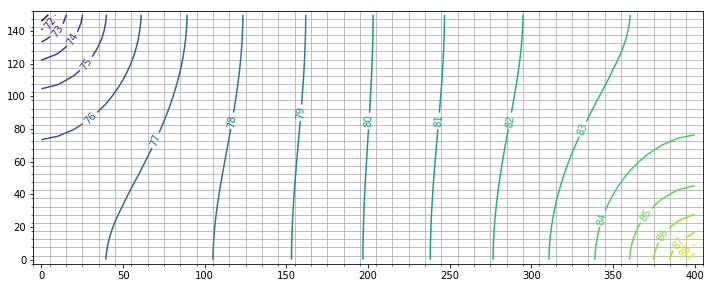

In [25]:
h = fdflow(nc, nr, L, W, k, H, Q, Fh)
x, y = xycenter(L, W)
plt.figure(figsize=((12, 6)))
cs = plt.contour(x, y, h, 20)
plt.clabel(cs, fmt='%1.0f')
plt.axis('scaled')
# add the grid
xg, yg = xygrid(L, W)
ax = plt.gca()
ax.xaxis.set_ticks(xg, minor=True);
ax.yaxis.set_ticks(yg, minor=True);
plt.grid(which='minor')
plt.xlim(xg[0], xg[-1])
plt.ylim(yg[0], yg[-1]);

## Exercise 1. Flow between two canals

Consider steady one-dimensional flow between two long, parallel canals. The canals are 1000 m apart. The canal on the left has a head $h=10$ m above the base of the aquifer and the canal on the right has a head $h=20$ m above the base of the aquifer. The hydraulic conductivity of the aquifer is 1 m/d. The recharge rate of the aquifer is 0.002 m/d. 

Questions:

a) Develop a finite difference solution using that the saturated thickness of the aquifer may be approximated as constant and equal to $H=15$ m. Compare your finite difference solution to the exact solution for an aquifer with $H=15$ m by creating a graph that shows both. 

b) Develop a finite difference solution for the case that the flow is unconfined and the saturated thickness of the aquifer varies with the head. You may need to iterate by adjusting the aquifer thickness several times. Compare your finite difference solution to the exact solution for unconfined flow by by creating a graph that shows both. 

*Solution*

$$\Phi = -\frac{N}{2}(x^2-xL) - \frac{\Phi_1 - \Phi_2}{L}x + \Phi_1$$

$$h = \frac{\Phi}{kH}$$

## Exercise 2. Flow to a well

Consider a confined aquifer with a hydraulic conductivity $k=10$ m/d and thickness $H=20$ m. Develop a square model of 2000 by 2000 meter. A well is located at the center of the model. The discharge of the well is 1000 m$^3$/d and the radius of the well is 0.2 m. The head along the model boundary is fixed to $40$ m. Compute a finite difference solution using 51 by 51 square cells. Make a contour plot of the head. In a separate figure, plot the head along a straight line through the center of the model together with the exact solution for a well in a circular island with radius 1000 m.

## Exercise 3. Improve the drawdown at the well
Try to improve the drawdown of your model at the well by dividing the cell that contains the well in 11 by 11 smaller cells. Hint: arrays may be put back-to-back using the `np.hstack` command.

## Exerise 4. Flow to a well near a river

Create a model for a well near a straight river that runs from North to South along the Eastern boundary of the model. The model is 3000 m long and 2000 m wide and the origin is at the lower-left hand corner. The river is located along $x=3000$. A well is located at $(x,y)=(2000,1000)$ and has discharge $Q=400$ m$^3$/d.  The groundwater flow is uniform towards the river in absence of the well with a gradient of $\partial h/\partial x = -0.002$. The aquifer is confined with $k=10$ m/d, and $H=20$ m.   The head in the river is 40 m. Use a rectangular grid. Create a contour plot of the head. What is the drawdown at the well (there is no need to refine at the well). 

## Discharge between cells

Functions are created to compute the discharge between cells in the $x$-direction and $y$ direction. Note that the array with cell-by-cell discharges in the $x$-direction has one column less that the array with head values. Similarly, the array with the cell-by-cell discharges in the $y$-direction has one row less than the array with head values. The discharge `U[i,j]` is the discharge through the right side of cell `i,j`. The  discharge `V[i,j]` is the discharge through the front side of cell `i,j`. 

In [26]:
def Ufunc(nc, nr, L, W, k, H, h):
    kH = k * H
    C = W[:, np.newaxis] * 2 * kH[:, :-1] * kH[:, 1:] / (
        kH[:, 1:] * L[:-1] + kH[:, :-1] * L[1:] )
    U = C * (h[:, :-1] - h[:, 1:])
    return U

def Vfunc(nc, nr, L, W, k, H, h):
    kH = k * H
    D = L * 2 * kH[:-1, :] * kH[1:, :] / (
        kH[1:, :] * W[:-1, np.newaxis] + kH[:-1, :] * W[1:, np.newaxis] )
    V = D * (h[:-1, :] - h[1:, :])
    return V

U = Ufunc(nc, nr, L, W, k, H, h)
V = Vfunc(nc, nr, L, W, k, H, h)

The stream function may be computed at the corners of the grid. 
To compute the stream function in the entire model, you need to know the stream function along one boundary. For example, for the previous exercise, both the top and bottom of the model are impermeable. Let's start at the top boundary and set the stream function equal to zero (or any other constant value) along the top boundary. The stream function at all other grid points (including the bottom boundary) may then be computed. Note that for this case with a well, the stream function is constant along the bottom boundary up to the well, after which it is again constant but the value is $Q$ less.

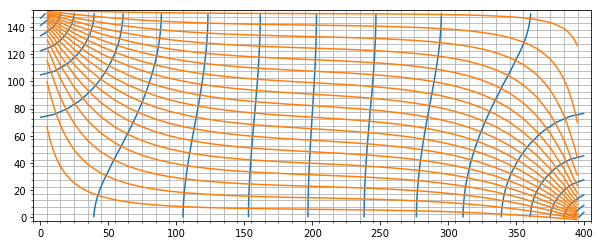

In [27]:
psi = np.zeros((nr + 1, nc - 1))
psi[1:, :] = -np.cumsum(U[::-1,:], 0)
xg, yg = xygrid(L, W)
plt.figure(figsize=(10, 6))
plt.contour(x, y, h, 20, colors='C0')
plt.contour(xg[1:-1], yg, psi, 20, colors='C1')
plt.axis('scaled')
# draw grid
xg, yg = xygrid(L, W)
ax = plt.gca()
ax.xaxis.set_ticks(xg, minor=True);
ax.yaxis.set_ticks(yg, minor=True);
plt.grid(which='minor')
plt.xlim(xg[0], xg[-1])
plt.ylim(yg[0], yg[-1]);

## Exercise 5. Discharge of the well

Compute the cell-by-cell flow for the problem of Exercise 4. Verify that the inflow into the cell that contains the well is indeed equal to $Q$. Determine the maximum discharge of the well such that no water is drawn from the river using visual inspection of the streamlines.

### Exercise 6. Variations in the hydraulic conductivity
Consider flow in a rectangular domain. The domain is 3000 m long and 2000 m wide. The head is fixed along the Western and Eastern boundaries, and are 46 m and 40 m, respectively. The North and South boundaries are impermeable. The aquifer is confined with $H=20$ m. Use square cells of 50 by 50 m. Make two models with different variations of the hydraulic conductivity:
1. The hydraulic conducitivity varies like a checkerboard, with squares of 1000 by 1000 m where the high fields have a hydraulic conductivity of 18 m/d and the low fields have a hydraulic conducitivty of 2 m/d.
2. The hydraulic conductivity varies randomly for each cell. The value of each cell is drawn from a Normal distribution with mean $\mu = 10$ and standard deviation $\sigma = 4$. Cells with a negative hydraulic conductivity are set to $k=0.001$ m/d. Random values may be generated with the `random.randn` function through multiplication with $\sigma$ and addition of $\mu$.

For each model, draw a flow net (a contour plot of the heads and streamlines), and compute the effective hydraulic conductivity. The effective $k$ is the uniform hydraulic conductivity that would result in exactly the same discharge in the model as the variable $k$ field. Note that this is not simply the mean hydraulic conducitivity (which is approximately 10 m/d for both models). 

In [28]:
#plt.matshow(k)
#plt.colorbar();
nc = 61
nr = 41
L = np.ones(nc) * 50
W = np.ones(nr) * 50
H = np.ones((nr,nc)) * 20
Q = np.zeros((nr,nc))
Fh = np.full((nr,nc) , np.nan)
Fh[:,0] = 46
Fh[:,-1] = 40
# 1
k_1 = np.zeros((nr,nc))
k_1[:20,:20] = 18
k_1[:20,20:40] = 2
k_1[:20,40:] = 18
k_1[20:,:20] = 2
k_1[20:,20:40] = 18
k_1[20:,40:] = 2
h_FDM_1 = fdflow(nc, nr, L, W, k_1, H, Q, Fh)
# 2
mean = 10
std = 4
k_2 = np.random.randn(nr,nc) * std + mean
for i in range(nr):
    for j in range(nc):
        k_2[i,j] = 0.001 if k_2[i,j]<0 else k_2[i,j]
h_FDM_2 = fdflow(nc, nr, L, W, k_2, H, Q, Fh)

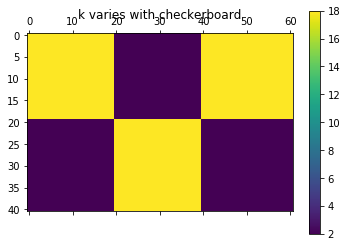

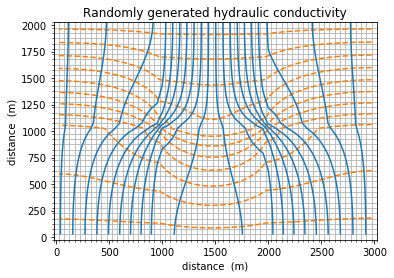

The uniform hydraulic conductivity is 5.50 m/d for the checkerboard case


In [29]:
U = Ufunc(nc, nr, L, W, k_1, H, h_FDM_1)
U_in = U[:,0].sum()
x, y = xycenter(L, W)
psi = np.zeros((nr + 1, nc - 1))
psi[1:, :] = -np.cumsum(U[::-1,:], 0)
xp, yp = xypsi(L, W)
xg, yg = xygrid(L, W)
plt.matshow(k_1)
plt.title('k varies with checkerboard')
plt.colorbar();
plt.figure()
plt.contour(xg[1:-1], yg, psi, 20, levels=np.arange(-820, 0, 40),colors='C1')
plt.contour(x, y + 0.5 * W[0], h_FDM_1, 20,colors='C0')
plt.axis('scaled')
plt.title("Randomly generated hydraulic conductivity")
plt.xlabel("distance  (m)")
plt.ylabel("distance  (m)")
plt.xlim(0, 3000)
plt.ylim(0, 2000)
xg, yg = xygrid(L, W)
ax = plt.gca()
ax.xaxis.set_ticks(xg, minor=True);
ax.yaxis.set_ticks(yg, minor=True);
plt.grid(which='minor')
plt.xlim(xg[0], xg[-1])
plt.ylim(yg[0], yg[-1]);
plt.show()
k_uniform = U_in/H[0,0]/2000*3000/(46-40)
print("The uniform hydraulic conductivity is %.2f m/d for the checkerboard case"%(k_uniform))

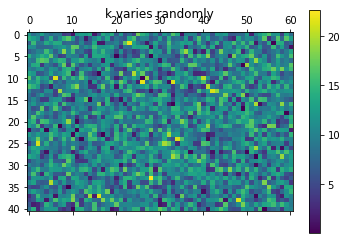

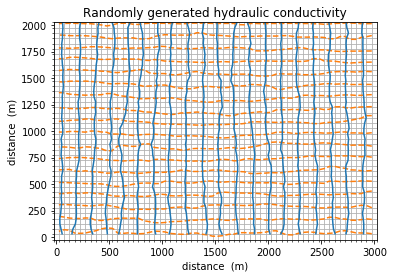

The uniform hydraulic conductivity is 8.79 m/d for the randomly generated case


In [30]:
U = Ufunc(nc, nr, L, W, k_2, H, h_FDM_2)
U_in = U[:,0].sum()
x, y = xycenter(L, W)
psi = np.zeros((nr + 1, nc - 1))
psi[1:, :] = -np.cumsum(U[::-1,:], 0)
xg, yg = xygrid(L, W)
xp, yp = xypsi(L, W)
plt.matshow(k_2)
plt.title('k varies randomly')
plt.colorbar();
plt.figure()
plt.contour(xg[1:-1], yg, psi, 20, levels=np.arange(-820, 0, 40),colors='C1')
plt.contour(x, y + 0.5 * W[0], h_FDM_2, 20, colors='C0')
plt.axis('scaled')
plt.title("Randomly generated hydraulic conductivity")
plt.xlabel("distance  (m)")
plt.ylabel("distance  (m)")
plt.xlim(0, 3000)
plt.ylim(0, 2000)
xg, yg = xygrid(L, W)
ax = plt.gca()
ax.xaxis.set_ticks(xg, minor=True);
ax.yaxis.set_ticks(yg, minor=True);
plt.grid(which='minor')
plt.xlim(xg[0], xg[-1])
plt.ylim(yg[0], yg[-1]);
plt.show()
k_uniform = U_in/H[0,0]/2000*3000/(46-40)
print("The uniform hydraulic conductivity is %.2f m/d for the randomly generated case"%(k_uniform))


### Semi-confined flow

The `fdflow` function is modified to include cells with a semi-confined top. The head $h^*$ above the aquifer and the resistance $c$ of the leaky layer on top of the aquifer need to be specified for each cell with a semi-confined top. Both $h^*$ and $c$ may vary from cell to cell. 

The water balance includes an additional source term $Q^*$ that represents the leakage from the overlying layer

$$Q^* = LW\frac{h^* - h}{c}$$

or 

$$Q^* = C^*(h^* - h)$$

where $C^*=LW/c$. The water balance equation now becomes

$$C_i h_{i+1} + D_i h_{i+n_c} + C_{i-1} h_{i-1} + D_{i-n_c} h_{i-n_c} - 
(C_i + D_i + C_{i-1} + D_{i-n_c}) h_i = -Q_i + C^*_i(h_i-h^*_i)$$

which can be rearranged to

$$C_i h_{i+1} + D_i h_{i+n_c} + C_{i-1} h_{i-1} + D_{i-n_c} h_{i-n_c} - 
(C_i + D_i + C_{i-1} + D_{i-n_c} + C^*_i) h_i = -Q_i -C^*_ih^*_i$$

The `fdflow` function is modfied to include semi-confined flow by requiring two additional input arrays: `hstar` and `c`. 

In [31]:
def fdflowsemi(nc, nr, L, W, k, H, Q, Fh, hstar, c):
    T = k * H
    W = W[:, np.newaxis]
    C = np.zeros((nr, nc))
    C[:, :-1] = W * 2 * T[:, :-1] * T[:, 1:] / (
                T[:, 1:] * L[:-1] + T[:, :-1] * L[1:])
    D = L * 2 * T[:-1, :] * T[1:, :] / (
        T[1:, :] * W[:-1] + T[:-1, :] * W[1:])
    C = C.ravel()[:-1]
    D = D.ravel()
    Cstar = (L * W / c).ravel()
    if len(D) == 0:
        A = diags([C, C], [1, -1], format='csr')  # model with 1 row
    else:
        A = diags([C, C, D, D], [1, -1, nc, -nc], format='csr')
    A -= diags(A.sum(1).A1 + Cstar, 0)
    rhs = -Q.ravel() - Cstar * hstar.flat[:]
    fixed = np.flatnonzero(~np.isnan(Fh))
    i, j = A[fixed].nonzero()
    A[fixed[i], j] = 0
    A[fixed, fixed] = 1
    rhs[fixed] = Fh.ravel()[fixed]
    h = spsolve(A, rhs)
    h.shape = (nr, nc)
    return h

### Exercise 7. Semi-confined flow

Create a model for one-dimensional flow in a semi-confined aquifer that is bounded on the left by a canal with fixed water level $h=1$ m and extends to infinity on the right side. The head above the semi-confining layer is $h^*=0$ m. The hydraulic conductivity is $k=10$ m/d, the thickness of the aquifer is $H=20$ m, and the resistance of the leaky layer is $c=1000$ days. Compare the answer of your finite difference solution to the exact solution by making a graph that shows both.

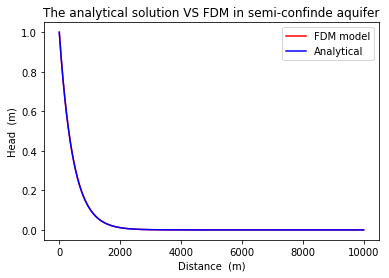

In [32]:
# Analytical
c = 1000
lab = np.sqrt(c*10*20)
X = np.linspace(0,10000,1001)
h_analytical = np.exp(-X/lab)
#FDM
nc = 1001
nr = 1
L = np.ones(nc) * 10
W = np.ones(nr) * 1
k = np.ones((nr,nc)) * 10
H = np.ones((nr,nc)) * 20
Q = np.zeros((nr,nc))
Fh = np.full((nr,nc), np.nan)
Fh[:,0] = 1
Fh[:,-1] = 0
hstar = np.ones((nr,nc))*0
h_FDM = fdflowsemi(nc, nr, L, W, k, H, Q, Fh, hstar, c)
plt.figure()
plt.plot(X,h_FDM[0],c='r', label='FDM model')
plt.plot(X,h_analytical,c='b', label = 'Analytical')
plt.title("The analytical solution VS FDM in semi-confinde aquifer")
plt.ylabel("Head  (m)")
plt.xlabel("Distance  (m)")
plt.legend()
plt.show()

## Transient flow

The transient water balance over a time period $\Delta t$ for cell $i$ may be written as

$$\text{In} - \text{Out} = \text{Increase in Storage}$$

or

$$(U_{i-1}+V_{i-n_c} + Q_i - U_i + V_i)\Delta t = S_i\Delta x_i \Delta y_i[h_i(t+\Delta t) - h_i(t)]$$

where $S_i$ is the storage coefficient of cell $i$. Rearrangement to the form we used for steady flow gives

$$-U_i - V_i + U_{i-1} + V_{i-n_c} = -Q_i + S_i\Delta x_i \Delta y_i [h_i(t+\Delta t) - h_i(t)] / \Delta t $$

The question now arises whether the cell-by-cell fluxes $U$ and $V$ should be computed with the heads at time $t$, time $t+\Delta t$, or some average of the two. When the heads at time $t$ are used, the scheme is called explicit and the time step $\Delta t$ needs to be chosen small enough to achieve a stable solution. When the heads at time $t+\Delta t$ are used, the scheme is called fully implicit and the solution is stable for any time step $\Delta t$ (although not necessarily accurate). When the mean of the heads at time $t$ and $t+\Delta t$ are used, the scheme is called the Crank-Nicholson scheme. This scheme is also implicit and the solution is stable for any time step $\Delta t$ and more accurate (for the same time step) as the fully implicit scheme. Here, we will implement the fully implicit method so that the finite difference equation for cell $i$ becomes

$$C_i h_{i+1} + D_i h_{i+n_c} + C_{i-1} h_{i-1} + D_{i-n_c} h_{i-n_c} - 
(C_i + D_i + C_{i-1} + D_{i-n_c} + B_i) h_i = -Q_i - B_ih_i^\text{old}$$

where all $h$ values are at time $t+\Delta t$, except for $h_i^\text{old}$, which is at time $t$, and $B_i=S_i\Delta x_i \Delta y_i/\Delta t$.

In [33]:
def fdflowtransient(nc, nr, L, W, k, H, Q, Fh, S, h0, delt, Nt):
    T = k * H
    W = W[:, np.newaxis]
    B = (S * L * W / delt).ravel()
    C = np.zeros((nr, nc))
    C[:, :-1] = W * 2 * T[:, :-1] * T[:, 1:] / (
                T[:, 1:] * L[:-1] + T[:, :-1] * L[1:])
    D = L * 2 * T[:-1, :] * T[1:, :] / (
        T[1:, :] * W[:-1] + T[:-1, :] * W[1:])
    C = C.ravel()[:-1]
    D = D.ravel()
    if len(D) == 0:
        A = diags([C, C], [1, -1], format='csr')  # model with 1 row
    else:
        A = diags([C, C, D, D], [1, -1, nc, -nc], format='csr')
    A -= diags(A.sum(1).A1 + B, 0)
    rhs = -Q.ravel()
    fixed = np.flatnonzero(~np.isnan(Fh))
    i, j = A[fixed].nonzero()
    A[fixed[i], j] = 0
    A[fixed, fixed] = 1
    # Empty matrix of heads
    h = np.empty((Nt + 1, nr, nc))
    h[0] = h0
    for i in range(Nt):
        rhsnew = rhs - B * h[i].ravel()
        rhsnew[fixed] = Fh.ravel()[fixed]
        hnew = spsolve(A, rhsnew)
        h[i + 1] = np.reshape(hnew, (nr, nc))    
    return h

### Exercise 8. Transient well
Create a transient flow model for a well with discharge $Q$. The well is located in an unconfined aquifer with storage coefficient $S=0.1$. The transmissivity may be approximated as constant with $k=10$ m/d, and $H=20$ m. Create a model of 101 by 101 cells of 20 by 20 m each. The boundary of the model is a no-flow boundary. The well has a discharge of 1000 m$^3$/d and is located at the center of the model and the initial head is zero everywhere. The exact solution for the head of a transient well in an infinite aquifer is given by the Theis solution 

$$h = -\frac{Q}{4\pi kD}\text{E}_1\left(\frac{Sr^2}{4 kD t}\right)$$

where E$_1$ is the exponential integral, which is available as `exp1` from the `scipy.special` package. 

Questions:
* Compare your finite difference solution after 100 days of pumping to the exact solution for both a time step of 10 days and a time step of 100 days. How does you solution compare?
* Compute a water balance for your entire finite difference model for the entire period of  100 days of pumping for both timesteps. Is the water balance met?
* Compare your finite difference solution after 500 days of pumping to the exact solution for both a time step of 10 days and a time step of 100 days. How does you solution compare?

In [34]:
from scipy.special import *

In [35]:
# 10 days time step
nc = 101
nr = 101
L = np.ones(nc) * 20
W = np.ones(nr) * 20
k = np.ones((nr,nc)) * 10
H = np.ones((nr,nc)) * 20
S = np.ones((nr,nc)) * 0.1
Q = np.zeros((nr,nc))
Q[50,50] = -1000
Fh = np.full((nr,nc),np.nan)
h0 = np.zeros((nr,nc))
delt_1 = 10
Nt_1 = 10
h_FDM_1 =  fdflowtransient(nc, nr, L, W, k, H, Q, Fh, S, h0, delt_1, Nt_1)
x,y = xycenter(L,W)
# Analytical with Imaginary well
x1, y1 = 1000, 1000
x2, y2 = 1000, 3000
x3, y3 = 1000, -1000
x4, y4 = -1000, 1000
x5, y5 = 3000, 1000
x_data = [x1,x2,x3,x4,x5]
y_data = [y1,y2,y3,y4,y5]
X = np.linspace(0,1000,1001)
Y = np.ones(len(X))*1000
h_analytical_100 = 0
for i in range(5):
    r = np.sqrt((x_data[i]-X)**2+(y_data[i]-Y)**2)
    h_analytical_100 += -1000/4/np.pi/10/20*exp1(0.1*r**2/4/10/20/100)
# 100 day time step
delt_2 = 100
Nt_2 = 1
h_FDM_2 =  fdflowtransient(nc, nr, L, W, k, H, Q, Fh, S, h0, delt_2, Nt_2)

Question 1

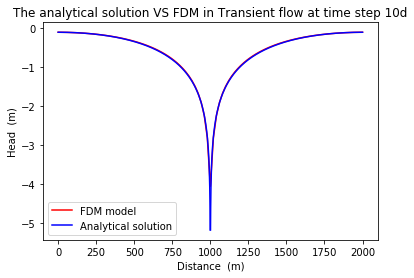

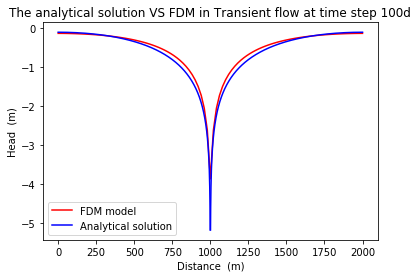

In [36]:
plt.figure()
plt.plot(x,h_FDM_1[-1,50,:],c='r', label='FDM model')
plt.plot(X,h_analytical_100,c='b', label='Analytical solution')
plt.plot(-X+2000,h_analytical_100,c='b')
plt.title("The analytical solution VS FDM in Transient flow at time step 10d")
plt.ylabel("Head  (m)")
plt.xlabel("Distance  (m)")
plt.legend()
plt.show()
plt.figure()
plt.plot(x,h_FDM_2[-1,50,:],c='r', label='FDM model')
plt.plot(X,h_analytical_100,c='b', label='Analytical solution')
plt.plot(-X+2000,h_analytical_100,c='b')
plt.title("The analytical solution VS FDM in Transient flow at time step 100d")
plt.ylabel("Head  (m)")
plt.xlabel("Distance  (m)")
plt.legend()
plt.show()

**Conclusion**

The fit for smaller time step is much better than larger one

Question 2

In [37]:
Vo_1 = 0
for i in range(Nt_1+1):
    U_1 = Ufunc(nc, nr, L, W, k, H, h_FDM_1[i])
    V_1 = Vfunc(nc, nr, L, W, k, H, h_FDM_1[i])
    Q_1 = -(U_1[50,50]+V_1[50,50]-U_1[50,49]-V_1[49,50])
    Vo_1 += Q_1*delt_1
additional_S_1 = (h_FDM_1[:-1,50,50]-h_FDM_1[1:,50,50])*L[0]*W[0]*S[0,0]
Vo_1 += additional_S_1.sum()
U_2 = Ufunc(nc, nr, L, W, k, H, h_FDM_2[-1])
V_2 = Vfunc(nc, nr, L, W, k, H, h_FDM_2[-1])
Q_2 = -(U_2[50,50]+V_2[50,50]-U_2[50,49]-V_2[49,50])
Vo_2 = Q_2*delt_2
additional_S_2 = (h_FDM_2[:-1,50,50]-h_FDM_2[1:,50,50])*L[0]*W[0]*S[0,0]
Vo_2 += additional_S_2.sum()
print("The total volume for time step 10d is %.2f m^3 and for time step 100d is %.2f m^3"%(Vo_1, Vo_2))

The total volume for time step 10d is 100000.00 m^3 and for time step 100d is 100000.00 m^3


Question 3

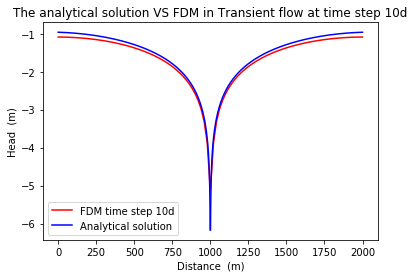

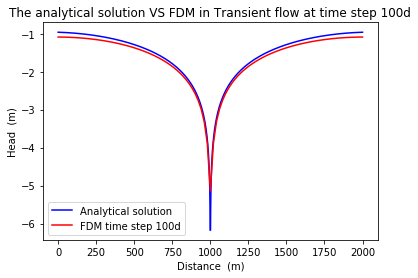

In [38]:
Nt_3 = 50
h_FDM_3 =  fdflowtransient(nc, nr, L, W, k, H, Q, Fh, S, h0, delt_1, Nt_3)
Nt_4 = 5
h_FDM_4 = fdflowtransient(nc, nr, L, W, k, H, Q, Fh, S, h0, delt_2, Nt_4)
# Analytical with Imaginary well
h_analytical_500 = 0
for i in range(5):
    r = np.sqrt((x_data[i]-X)**2+(y_data[i]-Y)**2)
    h_analytical_500 += -1000/4/np.pi/10/20*exp1(0.1*r**2/4/10/20/500)
plt.figure()
plt.plot(x,h_FDM_3[-1,50,:],c='r',label="FDM time step 10d")
plt.plot(X,h_analytical_500,c='b')
plt.plot(-X+2000,h_analytical_500,c='b', label='Analytical solution')
plt.legend()
plt.title("The analytical solution VS FDM in Transient flow at time step 10d")
plt.ylabel("Head  (m)")
plt.xlabel("Distance  (m)")
plt.show()
plt.figure()
plt.plot(X,h_analytical_500,c='b', label='Analytical solution')
plt.plot(-X+2000,h_analytical_500,c='b')
plt.plot(x,h_FDM_4[-1,50,:],c='r',label="FDM time step 100d")
plt.title("The analytical solution VS FDM in Transient flow at time step 100d")
plt.ylabel("Head  (m)")
plt.xlabel("Distance  (m)")
plt.legend()
plt.show()

**Conclusion**

1. after 500 days' pumping, the solution should approach steady state, while for analytical Theis solution, it will never reach that and moreover, it will go beyond. This is illustrated in the graph why the analytical solution is beyond FDM method at the end of the curve.

2. In this case, we only add four imaginary well based on symmetry once, but actually closer the result will be once taking infinite imaginary well into this system. This phenomenon becomes more obvious with time.

### Exercise 9
Consider the same model for transient flow to a well as discussed in the previous exercise, but now with zero constant-head boundaries all around the model. Simulate transient flow to the well with time steps of 10 days, but now turn the well off after 100 days. Simulate a total of 200 days (100 days of pumping plus 100 days of recovery). Plot the head vs time 20 m from the well. In the same graph, plot the exact solution. You should get a pretty good match.

In [39]:
def fdflowtransient_rec(nc, nr, L, W, k, H, Q, Fh, S, h0, delt, Nt, tlim):
    T = k * H
    W = W[:, np.newaxis]
    B = (S * L * W / delt).ravel()
    C = np.zeros((nr, nc))
    C[:, :-1] = W * 2 * T[:, :-1] * T[:, 1:] / (
                T[:, 1:] * L[:-1] + T[:, :-1] * L[1:])
    D = L * 2 * T[:-1, :] * T[1:, :] / (
        T[1:, :] * W[:-1] + T[:-1, :] * W[1:])
    C = C.ravel()[:-1]
    D = D.ravel()
    if len(D) == 0:
        A = diags([C, C], [1, -1], format='csr')  # model with 1 row
    else:
        A = diags([C, C, D, D], [1, -1, nc, -nc], format='csr')
    A -= diags(A.sum(1).A1 + B, 0)
    rhs = -Q.ravel()
    fixed = np.flatnonzero(~np.isnan(Fh))
    i, j = A[fixed].nonzero()
    A[fixed[i], j] = 0
    A[fixed, fixed] = 1
    # Empty matrix of heads
    h = np.empty((Nt + 1, nr, nc))
    h[0] = h0
    for i in range(Nt):
        if i*delt>=tlim:
            rhs = np.zeros((nr,nc)).ravel()
        rhsnew = rhs - B * h[i].ravel()
        rhsnew[fixed] = Fh.ravel()[fixed]
        hnew = spsolve(A, rhsnew)
        h[i + 1] = np.reshape(hnew, (nr, nc))    
    return h

In [40]:
nc = 101
nr = 101
L = np.ones(nc) * 20
W = np.ones(nr) * 20
k = np.ones((nr,nc)) * 10
H = np.ones((nr,nc)) * 20
S = np.ones((nr,nc)) * 0.1
Q = np.zeros((nr,nc))
Q[50,50] = -1000
Fh = np.full((nr,nc),np.nan)
Fh[:,0] = 0
Fh[:,-1] = 0
Fh[0,:] = 0
Fh[-1,:] = 0
h0 = np.zeros((nr,nc))
delt = 10
Nt = 20
h_FDM_1 =  fdflowtransient_rec(nc, nr, L, W, k, H, Q, Fh, S, h0, delt_1, Nt, 100)
# Analytical
T = np.arange(10,210,10)
h_analytical = np.zeros(len(T))
for i in range(len(T)):
    if T[i]<=100:
        h_analytical[i] = -1000/4/np.pi/10/20*exp1(0.1*20**2/4/10/20/T[i])
    else:
        h_analytical[i] = -1000/4/np.pi/10/20*exp1(0.1*20**2/4/10/20/T[i])+1000/4/np.pi/10/20*exp1(0.1*20**2/4/10/20/(T[i]-100))
h_analytical = np.hstack((0,h_analytical))

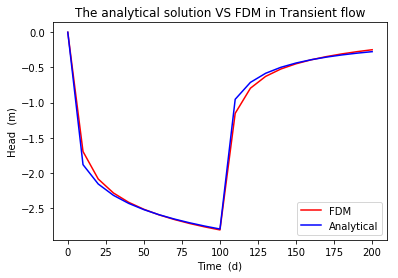

In [41]:
plt.figure()
plt.plot(np.arange(0,(Nt+1)*delt,delt),h_FDM_1[:,50,49],c='r',label='FDM')
plt.plot(np.arange(0,210,10),h_analytical,c='b',label='Analytical')
plt.title("The analytical solution VS FDM in Transient flow")
plt.ylabel("Head  (m)")
plt.xlabel("Time  (d)")
plt.legend()
plt.show()

### Exercise 10
Consider the same model as above, but now all model boundaries are impemeable except for the Eastern boundary which is a river with fixed head equal to zero. Pump the well for a period of 2500 days with a time step of 50 days. Compute and plot the total inflow from the stream vs. time. Does the inflow approach the discharge of the well after 2500 days?

In [42]:
nc = 101
nr = 101
L = np.ones(nc) * 20
W = np.ones(nr) * 20
k = np.ones((nr,nc)) * 10
H = np.ones((nr,nc)) * 20
S = np.ones((nr,nc)) * 0.1
Q = np.zeros((nr,nc))
Q[50,50] = -1000
Fh = np.full((nr,nc),np.nan)
Fh[:,-1] = 0
h0 = np.zeros((nr,nc))
delt = 50
Nt = 50
h_FDM =  fdflowtransient(nc, nr, L, W, k, H, Q, Fh, S, h0, delt, Nt)

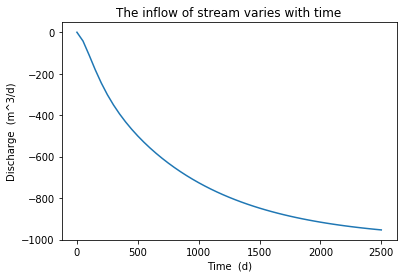

The inflow of stream is -953.71 m^3/d


In [43]:
Q = np.zeros(Nt+1)
U = [Ufunc(nc, nr, L, W, k, H, h_FDM[i])[:,-1].sum() for i in range(Nt+1)]
plt.figure()
plt.plot(np.arange(0,(Nt+1)*delt,delt), U)
plt.title("The inflow of stream varies with time")
plt.ylabel("Discharge  (m^3/d)")
plt.xlabel("Time  (d)")
plt.show()
print("The inflow of stream is %.2f m^3/d"%(U[-1]))

**The inflow of stream approximitely approaches 1000 m^3/d after 2500 days pumping.**